In [1]:
#Импорт необходимых библиотек
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [2]:
dataset_path = ('../DataSets/lego_minifigures')

df_index = pd.read_csv(os.path.join(dataset_path, 'index.csv'))
df_metadata = pd.read_csv(os.path.join(dataset_path, 'metadata.csv'))
df = pd.merge(df_index, df_metadata[['class_id', 'minifigure_name']], on='class_id')

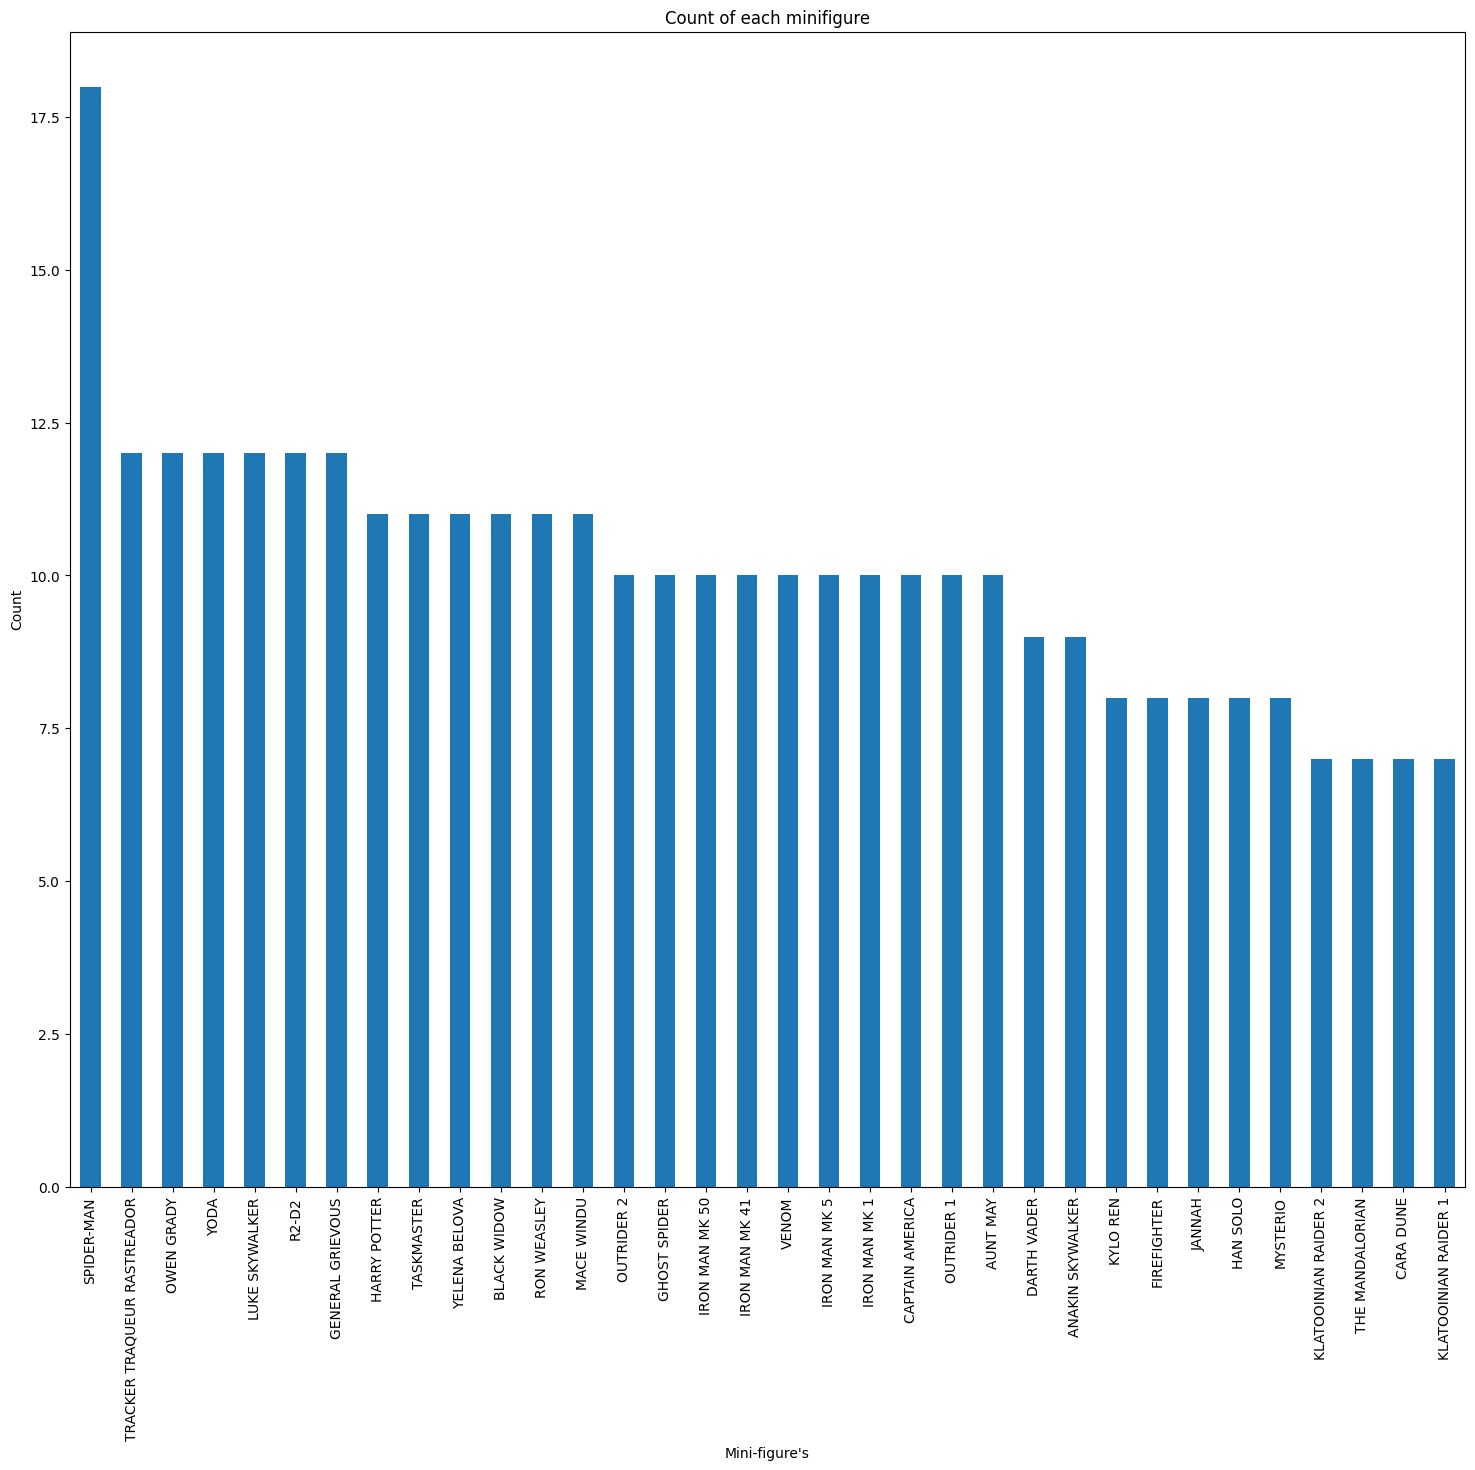

In [3]:
#Визуализация количества минифигурок каждого класса
ax0 = df['minifigure_name'].value_counts().plot(
    kind='bar',
    figsize = (18, 15),
    title='Count of each minifigure',
)
ax0.set_xlabel("Mini-figure's")
ax0.set_ylabel('Count')
plt.show()

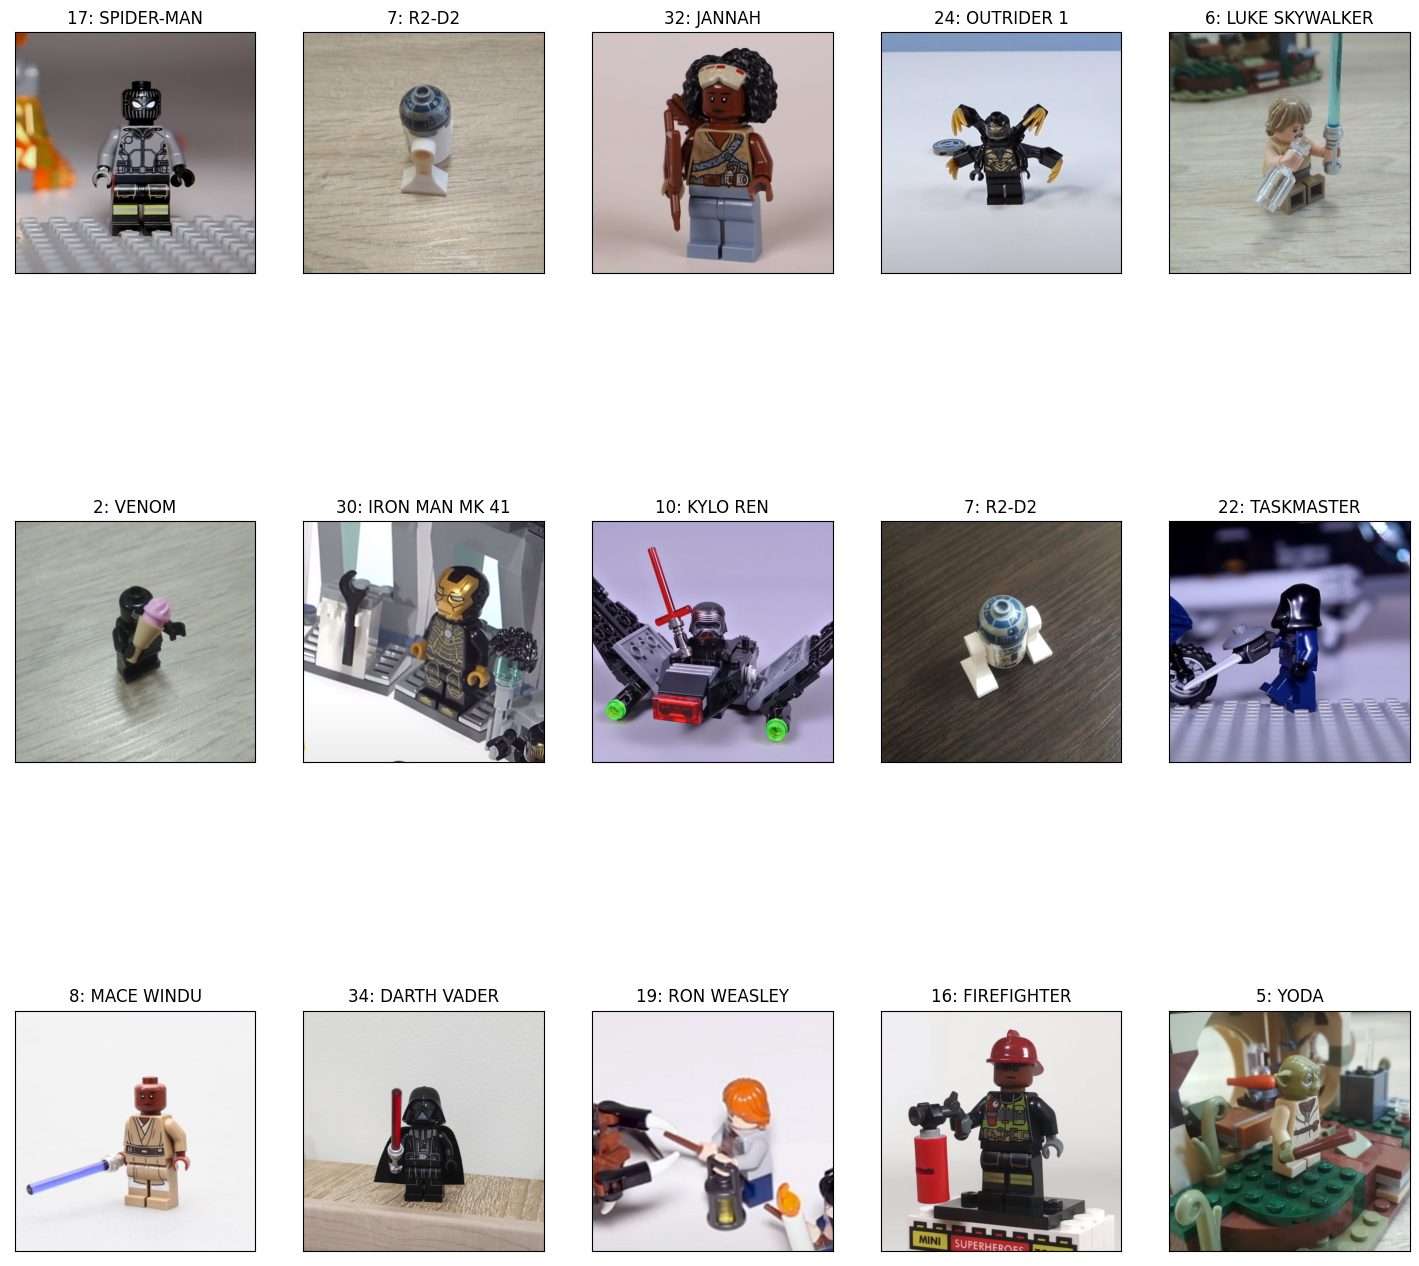

In [4]:
#Визуализация примеров для всех классов
plt1 = plt.figure(figsize=(18, 18))
for x,y in enumerate(df.sample(15).iterrows(), 1):
    plt.subplot(3, 5, x)
    image = cv2.imread(os.path.join(dataset_path, y[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"{y[1]['class_id']}: {y[1]['minifigure_name']}")
    plt.xticks([])
    plt.yticks([])

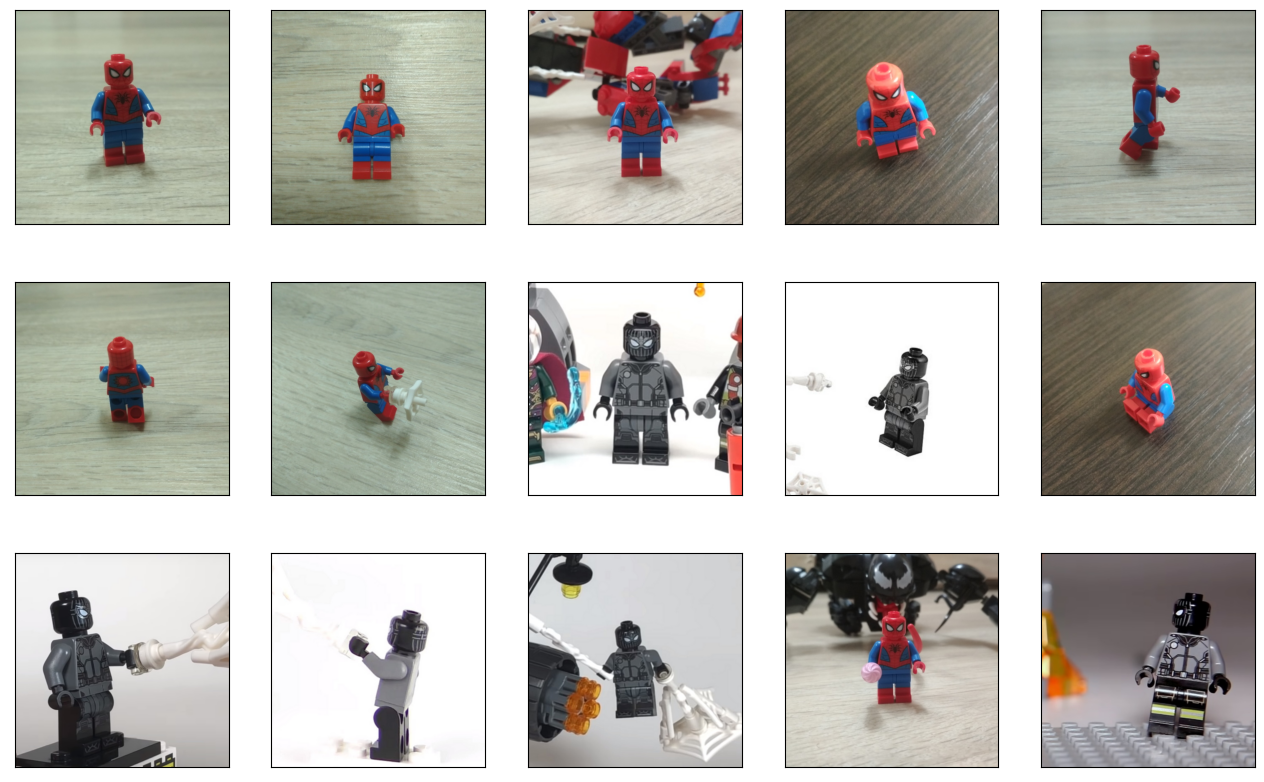

In [5]:
#Визуализация примеров для класса 'Spider-man'
plt2 = plt.figure(figsize=(16, 10))
for x, y in enumerate(df[df['minifigure_name']=='SPIDER-MAN'].sample(15).iterrows(), 1):
    plt.subplot(3, 5, x)
    image = cv2.imread(os.path.join(dataset_path, y[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [6]:
#Подготовка данных
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])

for i in range(1, len(df['class_id'].value_counts()) + 1):
    df_train = pd.concat([df_train, df[df['class_id'] == i].iloc[:-1]], ignore_index=True)
    df_valid = pd.concat([df_valid, df[df['class_id'] == i].iloc[-1:]], ignore_index=True)

In [7]:
#Инициализация и настройка DenseNet
base_model = tf.keras.applications.DenseNet121()
my_layer = Dropout(0.5)(base_model.layers[-2].output)
number_of_classes = len(df['class_id'].unique())
my_outputs = Dense(number_of_classes, activation="softmax")(my_layer)
model = Model(base_model.input, my_outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [8]:
#Преобразование данных
X_train = np.zeros((df_train.shape[0], 224, 224, 3))
for i in range(df_train.shape[0]):
    image = cv2.imread('../DataSets/lego_minifigures/' + df_train["path"].values[i])
    image = cv2.resize(image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_train[i] = image/255
Y_train = np.array(df_train["class_id"])-1
X_valid = np.zeros((df_valid.shape[0], 224, 224, 3))

for i in range(df_valid.shape[0]):
    image = cv2.imread('../DataSets/lego_minifigures/' + df_valid["path"].values[i])
    image = cv2.resize(image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_valid[i] = image/255
Y_valid = np.array(df_valid["class_id"])-1

In [9]:
#Настройка модели, сохранение результата наиболее удачной эпохи
checkpoint = ModelCheckpoint(filepath='LEGO_MINI.h5', monitor="accuracy", save_best_only=True, verbose=1)
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), shuffle=True,
          batch_size=4, callbacks=checkpoint)

Epoch 1/10


2023-03-06 16:01:05.885844: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


77/77 [==============================] - ETA: 0s - loss: 3.9507 - accuracy: 0.0749
Epoch 1: accuracy improved from -inf to 0.07492, saving model to LEGO_MINI.h5
77/77 [==============================] - 70s 812ms/step - loss: 3.9507 - accuracy: 0.0749 - val_loss: 2.7208 - val_accuracy: 0.2857
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 2.3470 - accuracy: 0.3779
Epoch 2: accuracy improved from 0.07492 to 0.37785, saving model to LEGO_MINI.h5
77/77 [==============================] - 71s 918ms/step - loss: 2.3470 - accuracy: 0.3779 - val_loss: 1.8299 - val_accuracy: 0.5714
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 1.4960 - accuracy: 0.6319
Epoch 3: accuracy improved from 0.37785 to 0.63192, saving model to LEGO_MINI.h5
77/77 [==============================] - 70s 909ms/step - loss: 1.4960 - accuracy: 0.6319 - val_loss: 1.1288 - val_accuracy: 0.8286
Epoch 4/10
77/77 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.8046

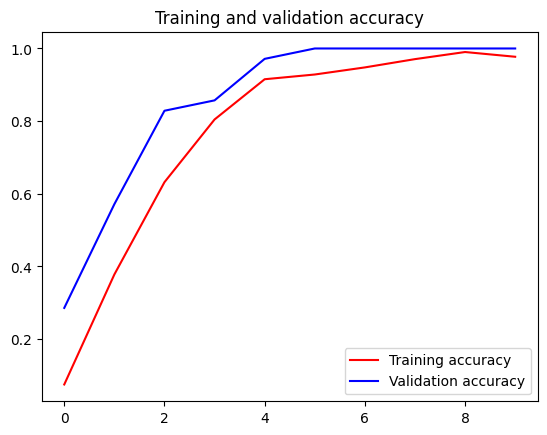

<Figure size 640x480 with 0 Axes>

In [10]:
#Training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

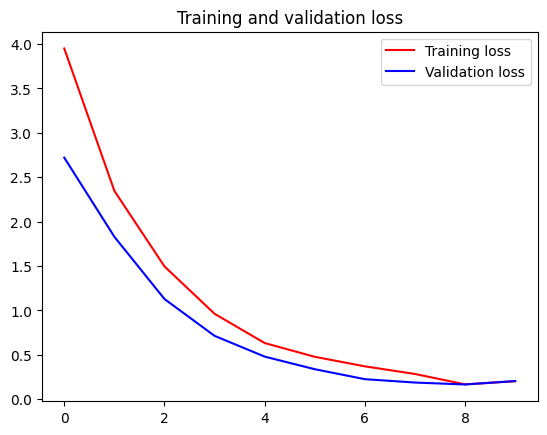

<Figure size 640x480 with 0 Axes>

In [11]:
#Training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()